
# Visualization -EigenCam (in progress)
**Author**: Hyeri

In [71]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model, Input 
import cv2
import random

labels_raf = {  0:  'Anger',
                1:  'Disgust',
                2:  'Fear',
                3:  'Happiness',
                4:  'Neutral',
                5:  'Sadness',
                6:  'Surprise'
            }
labels_fer = {  0:  'NF',
                1:  'anger',
                2:  'comtempt',
                3:  'disgust',
                4:  'fear',
                5:  'happiness',
                6:  'neutral',
                7:  'sadness',
                8:  'surprise',
                9:  'unknown'
            }
raw_labels_raf = {  1:  'Surprise',
                    2:  'Fear',
                    3:  'Disgust',
                    4:  'Happiness',
                    5:  'Sadness',
                    6:  'Anger',
                    7:  'Neutral'
                }
raw_labels_fer = {  1: 'neutral',
                    2: 'happiness',
                    3: 'surprise',
                    4: 'sadness',
                    5: 'anger',
                    6: 'disgust',
                    7: 'fear',
                    8: 'comtempt',
                    9: 'unknown',
                    10: 'NF'
                 }

model_fer = './models/model_ferplus_h.h5'
model_raf = './models/model_raf_h.h5'

labels_fer_j = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

In [72]:
def img_to_tensor(img_path, img_size=(100,100,3), RGB=True):
    img = cv2.imread(img_path, 1)[...,::-1]
    img_tensor = cv2.resize(img, img_size[:2])
    img_tensor = np.float32(img_tensor) / 255 if RGB else img_tensor
    return np.float32(img_tensor)

def pp_result(cam, img_tensor, result):
    _, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].set_title(result)
    axs[0].imshow(img_tensor)
    axs[0].imshow(cam, alpha=0.7)
    cam_adj = show_cam_on_image(img_tensor, cam)
    plt.title(result + ' (adjusted)')
    axs[1].imshow(cam_adj)
    plt.show()

def img_to_input_tensor(img_paths, num_imgs=None):
    if num_imgs > 0:
        img_paths = random.sample(img_paths,num_imgs)
    return np.array([img_to_tensor(img_path).astype(np.float32) for img_path in img_paths])

def get_img_list_raf(emotion : str):
    img_list = []
    folderpath = './data/RAF/'
    imgpath = './data/RAF/images/'
    labelling_list = open(folderpath + 'labels.txt', 'r').read().strip().split('\n')
    for name_label in labelling_list:
        image_name, label = name_label.split(' ')
        if raw_labels_raf[int(label)] == emotion and 'test' == image_name[:4]:
            name, fileend = image_name.split('.')
            filename = imgpath + name + '_aligned.' + fileend
            img_list.append(filename)
    return img_list

def get_img_list_fer(emotion : str):
    img_list = []
    csv_path = './data/ferplus2013/fer2013new.csv'
    test_dir = './data/ferplus2013/images/FER2013Test/'
    labelling_list = open(csv_path, 'r').read().strip().split('\n')
    for name_label in labelling_list:
        usage, file_name, neutral, happiness, surprise, sadness, anger, disgust, fear, contempt, unknown, NF = name_label.split(',')
        category = [neutral, happiness, surprise, sadness, anger, disgust, fear, contempt, unknown, NF]
        label = raw_labels_fer[np.argmax(category)+1]
        if label == emotion and usage=='PrivateTest':
            filepath = test_dir + file_name
            img_list.append(filepath)
    return img_list

def get_class_activation_map(activations):
    cams = []
    for i in range(activations.shape[0]):
        activation = activations[i][np.newaxis, ...]
        reshaped_activation = activation.reshape(activation.shape[3], -1).transpose()
        reshaped_activation -= reshaped_activation.mean(axis=0)
        _, _, VT = np.linalg.svd(reshaped_activation, full_matrices=True)
        projection = [activation[:,:,:,i] * VT[0,i] for i in range(activation.shape[3])]
        cam = np.zeros(shape = activation.shape[1:3])
        for filters in projection:
            cam += filters[0]
        cams.append(np.float32(cam))
    return cams

def scale_cam(cam, target_size=(100,100)):
    cam = cam - np.min(cam)
    cam = cam / (1e-7 + np.max(cam))
    cam = cv2.resize(cam, target_size)
    result = np.float32(cam)
    return result

def show_cam(emotion, num_imgs, show_all=False):
    img_paths = get_img_list_raf(emotion)
    input_tensors = img_to_input_tensor(img_paths, num_imgs)
    activations = activation_model.predict(input_tensors)
    cams = get_class_activation_map(activations)
    if show_all:
        return show_all_heatmaps(input_tensors, cams)
    else:
        return show_blended_only(cams)


def vec2label(onehot_vec):
    major_vote = np.argmax(onehot_vec)
    return labels_fer_j[major_vote]

def show_all_heatmaps(imgs: np.ndarray, cams: np.ndarray, colormap: int = cv2.COLORMAP_JET) :
    H, W = 2, 10
    _, axs = plt.subplots(H, W, figsize=(30, 30))
    blended_heatmap = np.zeros(shape=(100,100,3))
    for i in range(len(cams)):
        cam = cams[i]
        cam = scale_cam(cam)
        #classification_result = np.argmax(model.predict(imgs)[i])
        #title = labels_raf[classification_result] if input_model==model_raf else labels_fer[classification_result]
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), colormap)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = np.float32(heatmap) / 255
        if np.max(cam) > 1:
            raise Exception(
                "The input image should np.float32 in the range [0, 1]")
        idx = np.argmax(model.predict(imgs)[i])
        title =  labels_fer_j[idx]
        axs[i//W][i%W].set_title(title)
        axs[i//W][i%W].imshow(imgs[i])
        axs[i//W][i%W].imshow(heatmap, alpha=0.5)
        blended_heatmap += heatmap
    blended_heatmap -= np.min(blended_heatmap)
    blended_heatmap /= (1e-7 + np.max(blended_heatmap))
    axs[H-1][W-1].set_title('blended_heatmap')
    axs[H-1][W-1].imshow(blended_heatmap)
    plt.show()

def show_blended_only(cams: np.ndarray, colormap: int = cv2.COLORMAP_JET):
    blended_heatmap = np.zeros(shape=(100,100,3))
    mean_cams = np.array(cams).mean(axis=0)
    cams -= mean_cams
    for i in range(len(cams)):
        cam = cams[i]
        cam = scale_cam(cam)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), colormap)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = np.float32(heatmap) / 255
        if np.max(cam) > 1:
            raise Exception(
                "The input image should np.float32 in the range [0, 1]")
        heatmap /= np.max(heatmap)
        blended_heatmap += heatmap
    blended_heatmap /= np.max(blended_heatmap)
    plt.title('heatmap (' + emotion +') (' + str(cams.shape[0]) + ' images)' )
    plt.imshow(blended_heatmap)


## Model

In [73]:
"""
input_model = model_raf
model = load_model(input_model)
last_conv_layer_name = 'conv2d_7'
last_conv_layer = model.get_layer(last_conv_layer_name)
activation_model = tf.keras.Model(model.inputs, last_conv_layer.output)
"""

"\ninput_model = model_raf\nmodel = load_model(input_model)\nlast_conv_layer_name = 'conv2d_7'\nlast_conv_layer = model.get_layer(last_conv_layer_name)\nactivation_model = tf.keras.Model(model.inputs, last_conv_layer.output)\n"

In [74]:
# model
from ModelGenerator import get_base_model2
model_name = 'FERplus-impr-std_0124-1040_weights.h5'
model = get_base_model2((100,100,3))
model.add(tf.keras.layers.Dense(7, activation='softmax', name="softmax"))
model.load_weights('./models/' + model_name)

last_conv_layer_name = 'block3_conv3'
last_conv_layer = model.get_layer(last_conv_layer_name)
activation_model = tf.keras.Model(model.inputs, last_conv_layer.output)

## Settings

2022-01-26 17:57:55.347774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-26 17:57:55.687389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


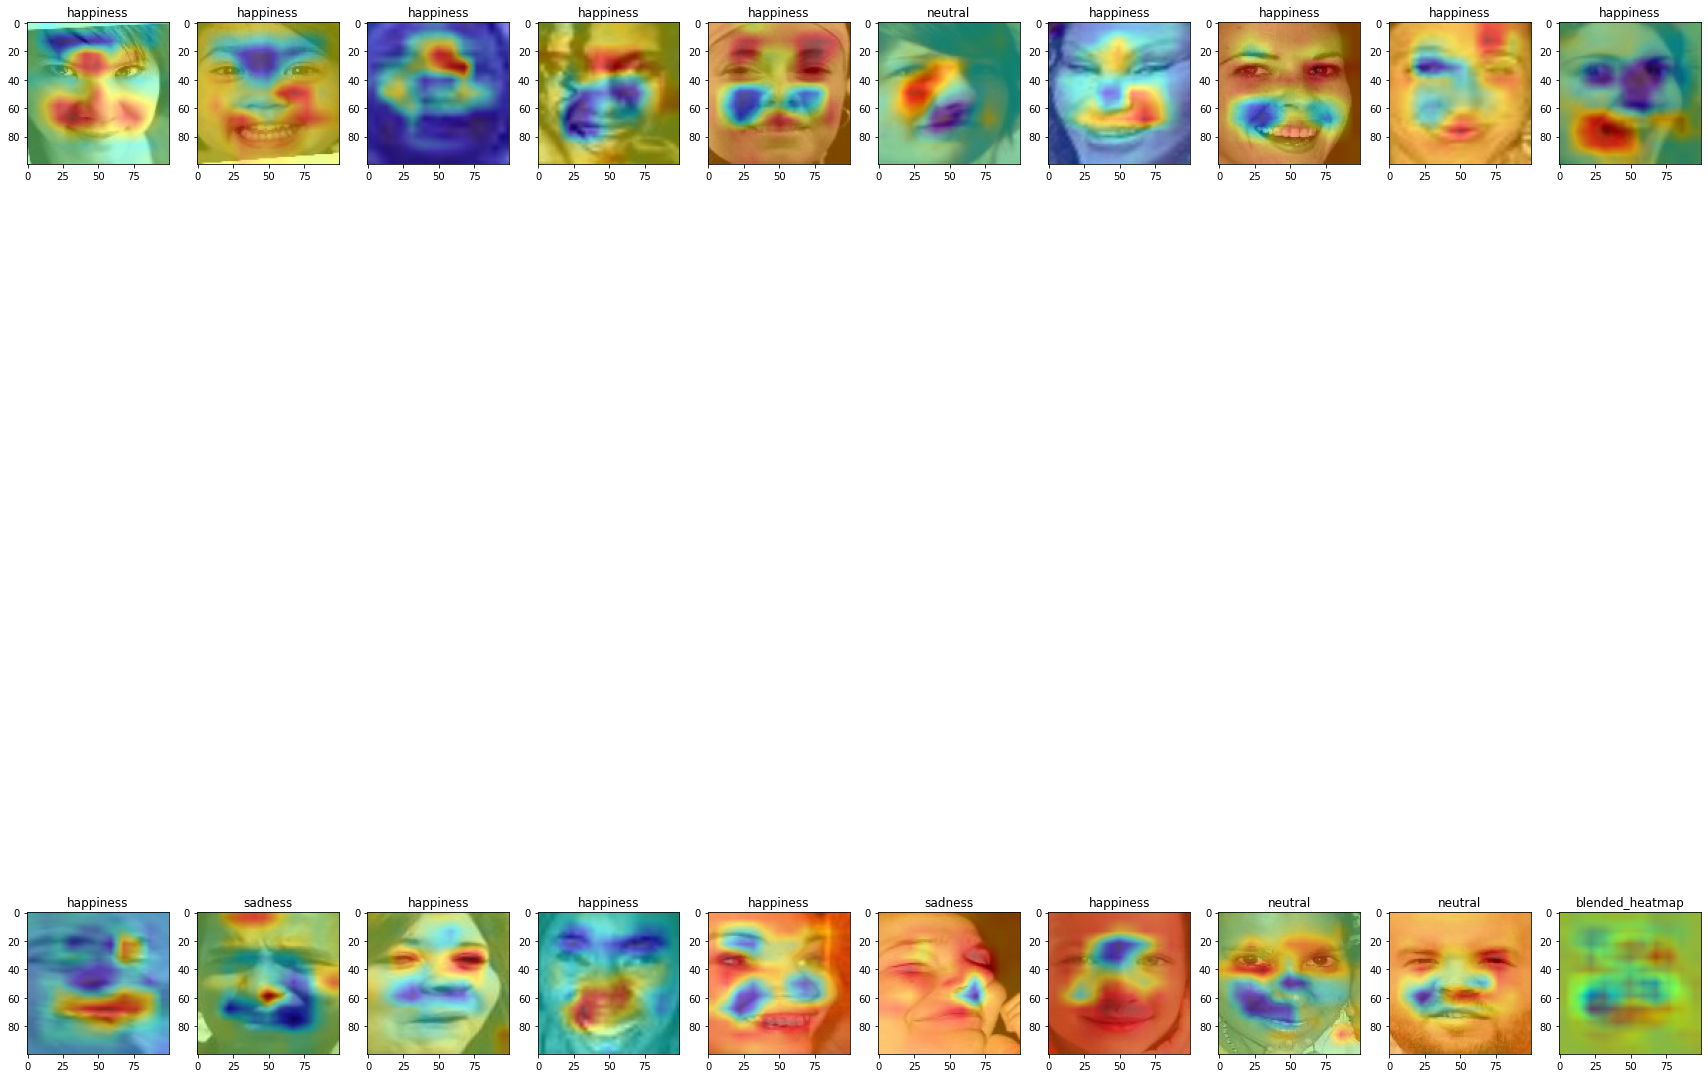

CPU times: user 2.62 s, sys: 781 ms, total: 3.4 s
Wall time: 2.24 s


In [75]:
%%time

emotion = 'Happiness'
num_imgs = 19

show_cam(emotion, num_imgs, show_all=True)